# Post Analysis for PDAC results

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import ot
import networkx as nx
from collections import defaultdict
from arboreto.algo import grnboost2
sc.settings.set_figure_params(dpi=80)

In [4]:
# decomposition results
weight_label_path = f"./PDAC_result.csv"
spot_deconv_res = sc.read_csv(weight_label_path)
spot_deconv_res

AnnData object with n_obs × n_vars = 428 × 20

# Clustering Using the Decomposition Results

c:\Users\jorda\.conda\envs\bio\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


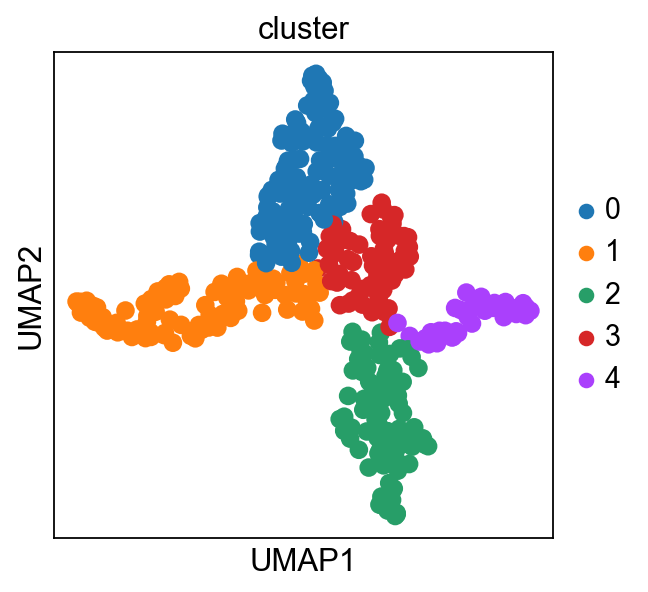

In [5]:
sc.pp.neighbors(spot_deconv_res, n_neighbors=15, use_rep="X")
sc.tl.umap(spot_deconv_res)
sc.tl.leiden(spot_deconv_res, key_added="cluster", resolution=0.2)
sc.pl.umap(spot_deconv_res, color=["cluster"])

In [7]:
# cluster number merge
adata_st = sc.read_h5ad(f"../data/PDAC-A/st_data.h5ad")
spot_deconv_res.obs.set_index(adata_st.obs.index, inplace=True)
adata_st.obs['cluster'] = spot_deconv_res.obs['cluster']
adata_st

c:\Users\jorda\.conda\envs\bio\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 428 × 19738
    obs: 'cluster'
    obsm: 'spatial'

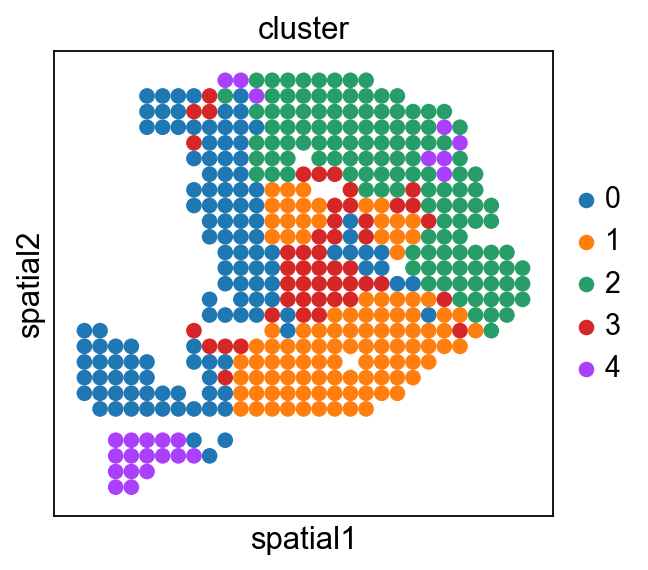

In [8]:
# smoothing and visualization
def refine_label(adata, radius=500, key='clusters'):
    n_neigh = radius
    new_type = []
    old_type = adata.obs[key].values
    
    #calculate distance
    position = adata.obsm['spatial']
    distance = ot.dist(position, position, metric='euclidean')
           
    n_cell = distance.shape[0]
    
    for i in range(n_cell):
        vec  = distance[i, :]
        index = vec.argsort()
        neigh_type = []
        for j in range(1, n_neigh+1):
            neigh_type.append(old_type[index[j]])
        max_type = max(neigh_type, key=neigh_type.count)
        new_type.append(max_type)
        
    new_type = [str(i) for i in list(new_type)]    
    
    return new_type
new_cluster = refine_label(adata_st, radius=10, key='cluster')
adata_st.obs['cluster'] = new_cluster

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.spatial(adata_st, color="cluster", spot_size=1, ax=axs, show=False)
axs.invert_yaxis() 
# you may get a different result due to the randomness of the PyG package
# but the overall distribution should be the same

# Calculate ARI and NMI Scores

In [9]:
# read region annotations
region = pd.read_table("./regeion_label_PDAC.txt", sep="\t", index_col=0) 
adata_st.obs['region_name'] = region['Region']
adata_st.obs['region_name'].fillna("Stroma", inplace=True)

region_dict = {
    "Stroma": 2, 
    "Cancer": 1 , 
    "Pancreatic": 3,
    "Duct Epithelium": 0
    }
adata_st.obs['region_num'] = adata_st.obs['region_name'].map(region_dict)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari_score = adjusted_rand_score(adata_st.obs['region_num'], adata_st.obs['cluster'])
nmi_score = normalized_mutual_info_score(adata_st.obs['region_num'], adata_st.obs['cluster'])
print(f"ARI Score: {ari_score}")
print(f"NMI Score: {nmi_score}")

ARI Score: 0.34519181472805205
NMI Score: 0.38531871671408047


# Regional Abundance Analysis

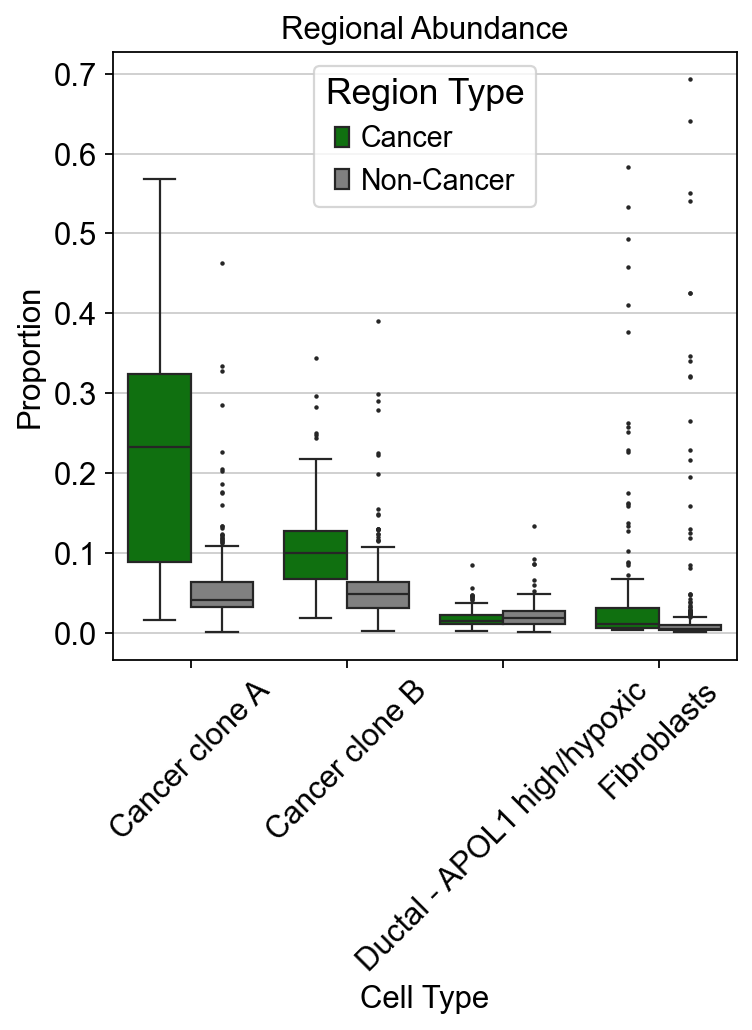

In [10]:
# data processing
cell_type_list = ['Cancer clone A', 'Cancer clone B', 'Ductal - APOL1 high/hypoxic', 'Fibroblasts']
abundance_dict = defaultdict(dict)
deconv_res_for_cancer = pd.DataFrame(spot_deconv_res.X, columns=spot_deconv_res.var_names, index=spot_deconv_res.obs_names)
deconv_res_for_cancer ['region_name'] = adata_st.obs['region_name']

for cell_type in cell_type_list:
    abundance_dict[cell_type]['Cancer'] = np.array(deconv_res_for_cancer[deconv_res_for_cancer['region_name'] == 'Cancer'][cell_type])
    abundance_dict[cell_type]['Non-Cancer'] = np.array(deconv_res_for_cancer[deconv_res_for_cancer['region_name'] != 'Cancer'][cell_type])

# visualization
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

plot_data = []
for cell_type, values in abundance_dict.items():
    for cancer_type, proportions in values.items():
        for proportion in proportions:
            plot_data.append([cell_type, cancer_type, proportion])

df = pd.DataFrame(plot_data, columns=['Cell Type', 'Region Type', 'Proportion'])
flierprops = dict(marker='o', markersize=1, linestyle='none')

plt.figure(figsize=(5, 5), dpi=80) 
sns.boxplot(x='Cell Type', y='Proportion', hue='Region Type', data=df, palette={'Cancer': 'green', 'Non-Cancer': 'gray'}, flierprops=flierprops)
plt.title('Regional Abundance')
plt.xticks(rotation=45)
plt.show()